In [1]:
import os
import time
import warnings
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import spectral
import pywt
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix)
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import (Layer, DepthwiseConv2D, Conv3D, Conv2D, Conv1D, MaxPooling1D, Dense, Dropout,
                          Flatten, Input, Reshape, MaxPooling2D, SeparableConv2D,
                          MaxPooling3D, MaxPooling2D, GlobalAveragePooling2D,
                          BatchNormalization, GlobalAveragePooling3D, concatenate, Reshape)
from keras_cv_attention_models import attention_layers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from keras.losses import categorical_crossentropy
from keras.models import Model, Sequential
# from keras.utils import np_utils
from tensorflow.keras.layers import (Activation, Lambda, multiply)
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from operator import truediv
from vit_keras import utils, vit
from keras.utils import to_categorical

2025-04-04 14:18:21.528375: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 14:18:21.567777: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-04 14:18:21.567813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-04 14:18:21.569011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 14:18:21.577095: I tensorflow/core/platform/cpu_feature_guar

**Mounting Drive and Loading HSIs**

In [ ]:
## Loading Datasets
def LoadHSIData(method):
    data_path = os.path.join(os.getcwd(),'../HSI/')
    if method == 'IP':
        HSI = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        GT = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
        Num_Classes = 16
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn',
                        'Grass-pasture', 'Grass-trees', 'Grass-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings',
                        'Stone-Steel']
    elif method == 'HC':
        HSI = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
        GT = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt'))['WHU_Hi_HanChuan_gt']
        Num_Classes = 16
        target_names = ['Strawberry', 'Cowpea', 'Soybean', 'Sorghum',
                        'Water spinach', 'Watermelon', 'Greens', 'Trees', 'Grass',
                        'Red roof', 'Gray roof', 'Plastic', 'Bare soil', 'Road',
                        'Bright object', 'Water']
    return HSI, GT, Num_Classes, target_names

**Important Internal Functions**



In [ ]:
## Prediction Model
def PreModel(Actual, model):
  prediction = model.predict(Actual)
  argmax_prediction = np.argmax(prediction, axis=1) + 1
  non_zero_classes = np.unique(argmax_prediction)
  if 0 in non_zero_classes:
    non_zero_classes = non_zero_classes[non_zero_classes != 0]
  Pre = argmax_prediction[np.isin(argmax_prediction, non_zero_classes)]
  return Pre

## Transform the Predicted Labels into Grouth Truths Shape
def Tranform_Labels(Sample_Matrix, Ind, Predicted):
  labels = np.zeros_like(Sample_Matrix)
  for index, value in zip(Ind, Predicted):
    row = index // Sample_Matrix.shape[1]
    col = index % Sample_Matrix.shape[1]
    if row < Sample_Matrix.shape[0] and col < Sample_Matrix.shape[1]:
        labels[row, col] = value
  return labels

## Computing the Accuracies and Confusion Matrix for Disjoint Samples
def ClassificationReports(TeC, HSID, Te_Pre, target_names):
  classification = classification_report(np.argmax(TeC, axis=1)+1, Te_Pre, target_names = target_names)
  oa = accuracy_score(np.argmax(TeC, axis=1)+1, Te_Pre)
  oa = round(oa, 4)
  confusion = confusion_matrix(np.argmax(TeC, axis=1)+1, Te_Pre)
  list_diag = np.diag(confusion)
  list_raw_sum = np.sum(confusion, axis=1)
  each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
  aa = np.mean(each_acc)
  aa = round(aa, 4)
  kappa = cohen_kappa_score(np.argmax(TeC, axis=1)+1, Te_Pre)
  kappa = round(kappa, 4)
  return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

## Computing the Accuracies and Confusion Matrix for Complete HSI
def ClassificationReports_HSI(TeC, HSID, Te_Pre, target_names):
  T_classification = classification_report(np.argmax(TeC, axis=1), np.argmax(Te_Pre, axis=1), target_names = target_names)
  T_oa = accuracy_score(np.argmax(TeC, axis=1), np.argmax(Te_Pre, axis=1))
  oa = round(T_oa, 4)
  T_confusion = confusion_matrix(np.argmax(TeC, axis=1), np.argmax(Te_Pre, axis=1))
  list_diag = np.diag(T_confusion)
  list_raw_sum = np.sum(T_confusion, axis=1)
  T_each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
  T_aa = np.mean(T_each_acc)
  T_aa = round(T_aa, 4)
  T_kappa = cohen_kappa_score(np.argmax(TeC, axis=1), np.argmax(Te_Pre, axis=1))
  T_kappa = round(T_kappa, 4)
  return T_classification, T_confusion, T_oa*100, T_each_acc*100, T_aa*100, T_kappa*100

## Plot Ground Truths for Complete Dataset as Trivial Cases
def GT_Plot(RDHSI, GT, model, WS, k, batch_size=256):
  height, width = GT.shape
  outputs = np.zeros((height, width))
  count = 0
  for i in range(0, len(RDHSI), batch_size):
    batch_RDHSI = RDHSI[i:i+batch_size]
    batch_pred = model.predict(batch_RDHSI)
    batch_pred_argmax = np.argmax(batch_pred, axis=1)
    batch_pred_argmax = batch_pred_argmax.reshape(-1)
    for j in range(len(batch_pred_argmax)):
      if count >= height * width:
        break
      target = int(GT[count // width, count % width])
      if target != 0:
        outputs[count // width, count % width] = batch_pred_argmax[j] + 1
      count += 1
  return outputs

## Convert GT and Predicted HSI GTs into one-Hot encoding
def Convert(GT, flattened):
  height, width = GT.shape
  unique_values = np.unique(flattened)
  unique_values = np.delete(unique_values, np.where(unique_values == 0))
  AB = len(unique_values)
  if len(unique_values) > AB:
    unique_values = unique_values[:AB]
  GTA = np.zeros((height * width, len(unique_values)), dtype=int)
  T_labels_flat = flattened.flatten()
  for idx, cls in enumerate(unique_values):
    GTA[:, idx] = (T_labels_flat == cls)
  return GTA

## Writing Results in CSV files
def CSVResults(file_name, Va_classification, Va_Confusion, Tr_Time, Va_Time,
               Te_Time, T_Time, Va_Kappa, Va_OA, Va_AA, Va_Per_Class,
               Te_classification, Te_Confusion, Te_Kappa, Te_OA, Te_AA, Te_Per_Class,
               T_classification, T_Confusion, T_Kappa, T_OA, T_AA, T_Per_Class, trainable_parameters):
    Va_classification = str(Va_classification)
    Va_Confusion = str(Va_Confusion)
    Te_classification = str(Te_classification)
    Te_Confusion = str(Te_Confusion)
    T_classification = str(T_classification)
    T_Confusion = str(T_Confusion)
    with open(file_name, 'w') as CSV_file:
      CSV_file.write('{} Tr_Time'.format(Tr_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Va_Time'.format(Va_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Te_Time'.format(Te_Time))
      CSV_file.write('\n')
      CSV_file.write('{} HSI_Time'.format(T_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Param'.format(trainable_parameters))
      CSV_file.write('\n')
      CSV_file.write('{} Va Kappa (%)'.format(Va_Kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Va Overall (%)'.format(Va_OA))
      CSV_file.write('\n')
      CSV_file.write('{} VA Average (%)'.format(Va_AA))
      CSV_file.write('\n')
      CSV_file.write('{} Te Kappa (%)'.format(Te_Kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Te Overall (%)'.format(Te_OA))
      CSV_file.write('\n')
      CSV_file.write('{} Te Average (%)'.format(Te_AA))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Kappa (%)'.format(T_Kappa))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Overall (%)'.format(T_OA))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Average (%)'.format(T_AA))
      CSV_file.write('\n')
      CSV_file.write('{} VA Per Class'.format(Va_Per_Class))
      CSV_file.write('\n')
      CSV_file.write('{} Te Per Class'.format(Te_Per_Class))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Per Class'.format(T_Per_Class))
      CSV_file.write('\n')
      CSV_file.write('{} VA Classification'.format(Va_classification))
      CSV_file.write('\n')
      CSV_file.write('{} VA Confussion'.format(Va_Confusion))
      CSV_file.write('\n')
      CSV_file.write('{} Te Classification'.format(Te_classification))
      CSV_file.write('\n')
      CSV_file.write('{} Te Confussion'.format(Te_Confusion))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Classification'.format(T_classification))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Confussion'.format(T_Confusion))
      CSV_file.write('\n')
    return CSV_file

**Dimensionality Reduction if Required**

In [4]:
## Dimensional Reduction
def DLMethod(HSI, NC = 75):
  RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
  pca = PCA(n_components = NC, whiten = True)
  RHSI = pca.fit_transform(RHSI)
  RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
  return RHSI

**Initializating Parameters**

In [ ]:
## Global Parameters
HSID = "IP" ## IP, HC, 
WS = 8
teRatio = 0.50
vrRatio = 0.50
k = 15
adam = tf.keras.optimizers.legacy.Adam(lr = 0.0001, decay = 1e-06)
epochs = 100
batch_size = 56

/home/ahmad/miniconda3/envs/hsi/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


**3D Patch Process**

In [6]:
## Creat Patches for 3D (Spatial-Spectral) Models
def ImageCubes(HSI, GT, WS=WS, removeZeroLabels=True):
    num_rows, num_cols, num_bands = HSI.shape
    margin = int(WS / 2)
    padded_data = np.pad(HSI, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    image_cubes = np.zeros((num_rows * num_cols, WS, WS, num_bands))
    patchesLabels = np.zeros((num_rows * num_cols))
    patchIndex = 0
    for r in range(margin, num_rows + margin):
        for c in range(margin, num_cols + margin):
            cube = padded_data[r - margin: r + margin, c - margin: c + margin, :]
            image_cubes[patchIndex, :, :, :] = cube
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    return image_cubes, patchesLabels

**Loading HSI and Creat Patchs**

In [7]:
HSI, GT, Num_Classes, target_names = LoadHSIData(HSID)
start = time.time()
RDHSI = DLMethod(HSI, NC = k)
end = time.time()
DL_Time = end - start
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)

**Disjoint Train/Validation/Test Sample Selection**

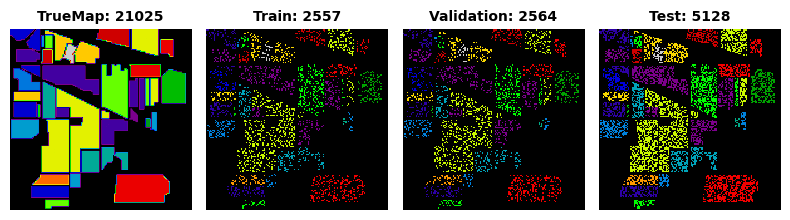

In [ ]:
np.random.seed(42)
num_rows, num_cols = GT.shape
flattened = GT.flatten()
unique_values, value_counts = np.unique(flattened, return_counts=True)
nonzero_indices = np.where(unique_values != 0)[0]
unique_values = unique_values[nonzero_indices]
Samples = pd.DataFrame(columns=['Training', 'Validation', 'Test'])
TrInd = []
VaInd = []
TeInd = []
for value in unique_values:
    class_indices = np.where(flattened == value)[0]
    train_indices, test_indices = train_test_split(class_indices, test_size=teRatio)
    train_indices, val_indices = train_test_split(train_indices, test_size=vrRatio)
    Samples.loc[value] = [len(train_indices), len(val_indices), len(test_indices)]
    TrInd.extend(train_indices)
    VaInd.extend(val_indices)
    TeInd.extend(test_indices)

file_name = f"{HSID}_{teRatio}_{vrRatio}_{k}_{WS}_Samples.csv"
Samples.to_csv(file_name, index_label='Class')
train_matrix = np.zeros_like(GT)
val_matrix = np.zeros_like(GT)
test_matrix = np.zeros_like(GT)
train_matrix.flat[TrInd] = 1
val_matrix.flat[VaInd] = 1
test_matrix.flat[TeInd] = 1
TRC = CGT[TrInd] -1
TRC_labels = Tranform_Labels(train_matrix, TrInd, TRC)
VAC = CGT[VaInd] -1
VAC_labels = Tranform_Labels(val_matrix, VaInd, VAC)
TEC = CGT[TeInd] -1
TEC_labels = Tranform_Labels(test_matrix, TeInd, TEC)
## Plot Ground Truths
cmap = 'nipy_spectral'
plt.figure(figsize=(8, 8))
plt.subplot(1, 4, 1)
plt.imshow(GT, cmap=cmap)
plt.title(f'TrueMap: {num_rows*num_cols}', fontsize=10, fontweight='bold')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(TRC_labels, cmap=cmap, interpolation='nearest')
plt.title(f'Train: {len(TrInd)}', fontsize=10, fontweight='bold')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(VAC_labels, cmap=cmap, interpolation='nearest')
plt.title(f'Validation: {len(VaInd)}', fontsize=10, fontweight='bold')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(TEC_labels, cmap=cmap, interpolation='nearest')
plt.title(f'Test: {len(TeInd)}', fontsize=10, fontweight='bold')
plt.axis('off')
plt.tight_layout()
## Save the plot
file_name = f"{HSID}_{teRatio}_{vrRatio}_{k}_{WS}_Train_Test_Mask.png"
plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)
## Select Train/Validation/Test Samples
Tr = CRDHSI[TrInd]
Va = CRDHSI[VaInd]
Te = CRDHSI[TeInd]
TrC = to_categorical(CGT[TrInd] -1)
VaC = to_categorical(CGT[VaInd] -1)
TeC = to_categorical(CGT[TeInd] -1)

**SCSNet**

**2D Exception Net**

In [10]:
def entry_flow(inputs):
    x = Conv2D(32, (3,3), strides = (2,2), padding = 'same')(inputs)
    x = Activation('relu')(x)
    x = Conv2D(64, 3, padding = 'same')(x)
    x = Activation('relu')(x)
    previous_block_activation = x
    for size in [128, 256, 512]:
        x = Activation('relu')(x)
        x = SeparableConv2D(size, (3, 3), padding = 'same')(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(size, (3, 3), padding = 'same')(x)
        x = MaxPooling2D((3, 3), strides = (2, 2), padding = 'same')(x)
        residual = Conv2D(size, (1, 1), strides = (2, 2), padding = 'same')(previous_block_activation)
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    return x

def middle_flow(x, num_blocks = 8):
    previous_block_activation = x
    for _ in range(num_blocks):
        x = Activation('relu')(x)
        x = SeparableConv2D(512, (3, 3), padding = 'same')(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(512, (3,3), padding = 'same')(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(512, (3,3), padding = 'same')(x)
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    return x

def exit_flow(x) :
    previous_block_activation = x
    x = Activation('relu')(x)
    x = SeparableConv2D(512, (3,3), padding='same')(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3,3), padding='same')(x)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    residual = Conv2D(728, (1,1), strides=(2,2), padding='same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
    x = Activation('relu')(x)
    x = SeparableConv2D(512, (3, 3), padding = 'same')(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding = 'same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(Num_Classes, activation='softmax')(x)
    return x

def Exception2D(WS, k, Num_Classes):
  inputs = Input(shape=(WS, WS, k))
  outputs = exit_flow(middle_flow(entry_flow(inputs)))
  model = Model(inputs, outputs, name='Exception2D')
  return model

**(2+1)D Exception Net**

In [11]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
      https://www.tensorflow.org/tutorials/video/video_classification
      https://arxiv.org/abs/1711.11248v3 (Original Paper for (2+1)D)
    """
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters, kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

def entry_block(inputs):
    x = Conv3D(filters=32, kernel_size=(5, 5, 3), activation='relu', padding = 'same')(inputs)
    x = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding = 'same')(x)
    previous_block_activation = x
    for size in [128, 256, 512]:
        # x = Activation('relu')(x)
        x = Conv2Plus1D(filters=size, kernel_size=(3, 3, 3), padding='same')(x)
        # x = Dropout(0.4)(x)
        # x = Activation('relu')(x)
        x = Conv2Plus1D(filters=size, kernel_size=(3, 3, 3), padding='same')(x)
        # x = Dropout(0.4)(x)
        x = MaxPooling3D(pool_size=(3, 3, 3), padding = 'same')(x)
        residual = Conv3D(size, kernel_size=(3, 3, 3), strides = (3, 3, 3), padding = 'same')(previous_block_activation)
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    return x

def middle_block(x, num_blocks = 8):
    previous_block_activation = x
    for _ in range(num_blocks):
        x = Activation('relu')(x)
        x = Conv2Plus1D(filters=128, kernel_size=(5, 3, 3), padding='same')(x)
        x = Activation('relu')(x)
        x = Conv2Plus1D(filters=256, kernel_size=(5, 3, 3), padding='same')(x)
        x = Activation('relu')(x)
        x = Conv2Plus1D(filters=512, kernel_size=(5, 3, 3), padding='same')(x)
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    return x

def exit_block(x) :
    previous_block_activation = x
    x = Activation('relu')(x)
    x = Conv2Plus1D(filters=512, kernel_size=(3, 3, 3), padding='same')(x)
    # x = Dropout(0.4)(x)
    x = Activation('relu')(x)
    x = Conv2Plus1D(filters=728, kernel_size=(3, 3, 3), padding='same')(x)
    # x = Dropout(0.4)(x)
    x = MaxPooling3D(pool_size=(3, 3, 3), padding = 'same')(x)
    residual = Conv3D(728, kernel_size=(3, 3, 3), padding = 'same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
    x = Activation('relu')(x)
    x = Conv2Plus1D(filters=512, kernel_size=(3, 3, 3), padding='same')(x)
    # x = Dropout(0.4)(x)
    x = Activation('relu')(x)
    x = Conv2Plus1D(filters=256, kernel_size=(3, 3, 3), padding='same')(x)
    x = Dropout(0.4)(x)
    x = GlobalAveragePooling3D()(x)
    x = Dense(Num_Classes, activation='softmax')(x)
    return x

def Xtreme_Exception(WS, k, Num_Classes):
  inputs = Input(shape=(WS, WS, k, 1))
  outputs = exit_block(middle_block(entry_block(inputs)))
  model = Model(inputs, outputs, name='Xtreme_Exception')
  return model

**2D CNN Model**

In [12]:
def CNN2D(WS, k, Num_Classes):
    input_layer = Input((WS, WS, k))
    conv_layer1 = Conv2D(filters=8, kernel_size=(3, 3), padding = 'same', activation='relu')(input_layer)
    conv_layer2 = Conv2D(filters=16, kernel_size=(3, 3), padding = 'same', activation='relu')(conv_layer1)
    conv_layer3 = Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', activation='relu')(conv_layer2)
    conv_layer4 = Conv2D(filters=64, kernel_size=(3, 3), padding = 'same', activation='relu')(conv_layer3)
    flatten_layer = Flatten()(conv_layer4)
    dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=Num_Classes, activation='softmax')(dense_layer2)
    model = Model(inputs=input_layer, outputs=output_layer, name='CNN2D')
    return model

**2D inception Net**

In [ ]:
def IN2D(WS, k,Num_Classes):
    input_img = Input(shape=(WS, WS, k))
    layer_1 = Conv2D(30, (1, 1), padding = 'same', activation = 'relu')(input_img)
    layer_1 = Conv2D(20, (1, 1), padding = 'same', activation = 'relu')(layer_1)
    layer_1 = Conv2D(10, (3, 3), padding = 'same', activation = 'relu')(layer_1)
    layer_2 = Conv2D(40, (1, 1), padding = 'same', activation = 'relu')(input_img)
    layer_2 = Conv2D(20, (1, 1), padding = 'same', activation = 'relu')(layer_2)
    layer_2 = Conv2D(10, (5, 5), padding = 'same', activation = 'relu')(layer_2)
    layer_3 = MaxPooling2D((3, 3), strides = (1, 1), padding = 'same')(input_img)
    layer_3 = Conv2D(20, (1, 1), padding = 'same', activation = 'relu')(layer_3)
    layer_3 = Conv2D(10, (1, 1), padding = 'same', activation = 'relu')(layer_3)
    mid_1 = keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)
    layer_4 = Conv2D(128, (1, 1), activation = 'relu')(mid_1)
    flat_1 = Flatten()(layer_4)
    dense_1 = Dense(1200, activation = 'relu')(flat_1)
    dense_2 = Dense(600, activation = 'relu')(dense_1)
    dense_3 = Dense(150, activation = 'relu')(dense_2)
    output = Dense(Num_Classes, activation = 'softmax')(dense_3)
    model = Model([input_img], output, name='IN2D')
    return model

**3D inception Net**

In [ ]:
def IN3D(WS, k,Num_Classes):
    input_img = Input(shape=(WS, WS, k, 1))
    layer_1 = Conv3D(30, (5, 5, 7), padding = 'same', activation='relu')(input_img)
    layer_1 = Conv3D(20, (3, 3, 5), padding = 'same', activation='relu')(layer_1)
    layer_1 = Conv3D(10, (3, 3, 3), padding = 'same', activation='relu')(layer_1)
    layer_2 = Conv3D(40, (5, 5, 7), padding = 'same', activation='relu')(input_img)
    layer_2 = Conv3D(20, (3, 3, 5), padding = 'same', activation='relu')(layer_2)
    layer_2 = Conv3D(10, (3, 3, 3), padding = 'same', activation='relu')(layer_2)
    layer_3 = Conv3D(60, (5, 5, 7), padding = 'same', activation='relu')(input_img)
    layer_3 = Conv3D(30, (3, 3, 5), padding = 'same', activation='relu')(layer_3)
    layer_3 = Conv3D(10, (3, 3, 3), padding = 'same', activation='relu')(layer_3)
    mid_1 = keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)
    layer_4 = Conv3D(128, (1, 1, 1), activation = 'relu')(mid_1)
    flat_1 = Flatten()(layer_4)
    dense_1 = Dense(512, activation='relu')(flat_1)
    dense_1 = Dropout(0.4)(dense_1)
    dense_2 = Dense(128, activation='relu')(dense_1)
    dense_2 = Dropout(0.4)(dense_2)
    dense_3 = Dense(64, activation='relu')(dense_2)
    dense_3 = Dropout(0.4)(dense_3)
    output = Dense(Num_Classes, activation='softmax')(dense_3)
    model = Model([input_img], output, name='IN3D')
    return model

**Hybrid Inception Net**

In [ ]:
def HybIN(WS, k,Num_Classes):
    input_img = Input(shape=(WS, WS, k, 1))
    layer_1 = Conv3D(30, (5, 5, 7), padding = 'same', activation='relu')(input_img)
    layer_1 = Conv3D(20, (3, 3, 5), padding = 'same', activation='relu')(layer_1)
    layer_1 = Conv3D(10, (3, 3, 3), padding = 'same', activation='relu')(layer_1)
    layer_1_shape = layer_1.shape
    layer_1 = Reshape((layer_1_shape[1], layer_1_shape[2], layer_1_shape[3]*layer_1_shape[4]))(layer_1)
    layer_1 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_1)
    layer_1 = Conv2D(filters = 16, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_1)
    layer_1 = Conv2D(filters = 32, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_1)
    layer_1 = Conv2D(filters = 64, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_1)
    layer_2 = Conv3D(40, (5, 5, 7), padding = 'same', activation = 'relu')(input_img)
    layer_2 = Conv3D(20, (3, 3, 5), padding = 'same', activation = 'relu')(layer_2)
    layer_2 = Conv3D(10, (3, 3, 3), padding = 'same', activation = 'relu')(layer_2)
    layer_2_shape = layer_2.shape
    layer_2 = Reshape((layer_2_shape[1], layer_2_shape[2], layer_2_shape[3]*layer_2_shape[4]))(layer_2)
    layer_2 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_2)
    layer_2 = Conv2D(filters = 16, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_2)
    layer_2 = Conv2D(filters = 32, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_2)
    layer_2 = Conv2D(filters = 64, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_2)
    layer_3 = Conv3D(60, (5, 5, 7), padding = 'same', activation='relu')(input_img)
    layer_3 = Conv3D(30, (3, 3, 5), padding = 'same', activation='relu')(layer_3)
    layer_3 = Conv3D(10, (3, 3, 3), padding = 'same', activation='relu')(layer_3)
    layer_3_shape = layer_3.shape
    layer_3 = Reshape((layer_3_shape[1], layer_3_shape[2], layer_3_shape[3]*layer_3_shape[4]))(layer_3)
    layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_3)
    layer_3 = Conv2D(filters = 16, kernel_size=(1, 1), padding = 'same', activation = 'relu')(layer_3)
    layer_3 = Conv2D(filters = 32, kernel_size=(1, 1), padding = 'same', activation = 'relu')(layer_3)
    layer_3 = Conv2D(filters = 64, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_3)
    mid_1 = keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)
    layer_4 = Conv2D(filters = 128, kernel_size = (1, 1), padding = 'same', activation = 'relu')(mid_1)
    flat_1 = Flatten()(layer_4)
    dense_1 = Dense(512, activation='relu')(flat_1)
    dense_1 = Dropout(0.4)(dense_1)
    dense_2 = Dense(128, activation='relu')(dense_1)
    dense_2 = Dropout(0.4)(dense_2)
    dense_3 = Dense(64, activation='relu')(dense_2)
    dense_3 = Dropout(0.4)(dense_3)
    output = Dense(Num_Classes, activation='softmax')(dense_3)
    model = Model([input_img], output, name='HybIN')
    return model

**Hybrid CNN**

In [ ]:
def HybCNN(WS, k,Num_Classes):
    input_layer = Input((WS, WS, k, 1))
    conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), padding = 'same', activation='relu')(input_layer)
    conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), padding = 'same', activation='relu')(conv_layer1)
    conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), padding = 'same', activation='relu')(conv_layer2)
    conv3d_shape = conv_layer3.shape
    conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
    conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), padding = 'same', activation='relu')(conv_layer3)
    flatten_layer = Flatten()(conv_layer4)
    dense_layer1 = Dense(units=256, activation = 'relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units = 128, activation = 'relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units = Num_Classes, activation = 'softmax')(dense_layer2)
    model = Model(inputs = input_layer, outputs = output_layer, name='HybCNN')
    return model

**A Fast and Compact 3D CNN**

In [17]:
def CNN3D(WS, k, Num_Classes):
    input_layer = Input((WS, WS, k, 1))
    conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), padding = 'same', activation='relu')(input_layer)
    conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), padding = 'same', activation='relu')(conv_layer1)
    conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), padding = 'same', activation='relu')(conv_layer2)
    conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), padding = 'same', activation='relu')(conv_layer3)
    flatten_layer = Flatten()(conv_layer4)
    dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    output_layer = Dense(units = Num_Classes, activation='softmax')(dense_layer2)
    model = Model(inputs=input_layer, outputs=output_layer, name='CNN3D')
    return model

**Attention Graph-based CNN**

In [ ]:
def AttentionGCN(WS, k, Num_Classes):
    input_layer = Input(shape=(WS, WS, k), name='input')
    conv1 = Conv2D(8, kernel_size=1, activation='relu', name='conv1', kernel_regularizer=regularizers.l2(0.0005))(input_layer)
    nn = attention_layers.cot_attention(conv1, kernel_size=3)
    graph_t = Reshape((8, WS*WS))(conv1)
    squeezed_graph_t = Conv1D(16, 1, activation='relu', name='squeezer', kernel_regularizer=regularizers.l2(0.0001))(graph_t)
    squeezed_graph = Reshape((8, 16))(squeezed_graph_t)
    gconv = Conv1D(64, 1, activation='relu', name='gconv', kernel_regularizer=regularizers.l2(0.0001))(squeezed_graph)
    gconv_t = Reshape((8, 64))(gconv)
    unsqueezed_graph_transpose = Conv1D(64, 1, activation='relu', name='unsqueezer', kernel_regularizer=regularizers.l2(0.0001))(gconv_t)
    unsqueezed_graph = Reshape((64, 8))(unsqueezed_graph_transpose)
    glore = Reshape((8, WS, WS))(unsqueezed_graph)
    block1 = layers.concatenate([conv1, glore], axis=-1)
    block12 = layers.concatenate([conv1, block1, nn], axis=-1)
    conv2 = Conv2D(32, kernel_size=1, activation='relu', name='conv2', kernel_regularizer=regularizers.l2(0.0005))(block12)
    graph_t2 = Reshape((32,WS*WS))(conv2)
    squeezed_graph_t2 = Conv1D(64, 1, activation='relu', name='squeezer2', kernel_regularizer=regularizers.l2(0.0001))(graph_t2)
    squeezed_graph2 = Reshape((64, 32))(squeezed_graph_t2)
    gconv2 = Conv1D(32, 1, activation='relu', name='gconv2', kernel_regularizer=regularizers.l2(0.0001))(squeezed_graph2)
    gconv_transpose2 = Reshape((64, 32))(gconv2)
    unsqueezed_graph_t2 = Conv1D(8*8, 1, activation='relu', name='unsqueezer2', kernel_regularizer=regularizers.l2(0.0001))(gconv_transpose2)
    unsqueezed_graph2 = Reshape((8*8, 64))(unsqueezed_graph_t2)
    glore2 = Reshape((8, 8, 64))(unsqueezed_graph2)
    block2 = layers.concatenate([conv2, glore2], axis=-1)
    block21 = layers.concatenate([conv2, block2, nn], axis=-1)
    conv3 = Conv2D(32, kernel_size=1, activation='relu', name='conv3', kernel_regularizer=regularizers.l2(0.0005))(block21)
    conv4 = Conv2D(64, kernel_size=3, activation='relu', name='conv4', kernel_regularizer=regularizers.l2(0.0005))(conv3)
    conv5 = Conv2D(128, kernel_size=1, activation='relu', name='conv5', kernel_regularizer=regularizers.l2(0.0005))(conv4)
    flat = Flatten()(conv5)
    fc1 = Dense(100, activation='relu', name='fc1', kernel_regularizer=regularizers.l2(0.01))(flat)
    fc2 = Dense(20, activation='relu', name='fc2', kernel_regularizer=regularizers.l2(0.01))(fc1)
    fc3 = Dense(Num_Classes, activation='softmax', name='fc3', kernel_regularizer=regularizers.l2(0.0001))(fc2)
    model = Model(inputs=input_layer, outputs=fc3, name='AttentionGCN')
    return model

In [ ]:
class SCS(layers.Layer):
    def __init__(self, kernel_size, units=32, stride=1, depthwise_separable=False, padding='same'):
        super(SCS, self).__init__()
        self.depthwise_separable = depthwise_separable
        self.units = units
        assert kernel_size in [1, 3, 5], "other size not supported"
        self.kernel_size = kernel_size
        if self.kernel_size == 1:
            self.stack = lambda x: x
        elif self.kernel_size == 3:
            self.stack = self.stack3x3
        elif self.kernel_size == 5:
            self.stack = self.stack5x5
        self.stride = stride
        if padding == 'same':
            self.pad = self.kernel_size // 2
            self.pad_1 = 1
            self.clip = 0
        elif padding == 'valid':
            self.pad = 0
            self.pad_1 = 0
            self.clip = self.kernel_size // 2

    def build(self, input_shape):
        self.in_shape = input_shape
        self.out_y = math.ceil((self.in_shape[1] - 2*self.clip) / self.stride)
        self.out_x = math.ceil((self.in_shape[2] - 2*self.clip) / self.stride)
        self.flat_size = self.out_x * self.out_y
        self.channels = self.in_shape[3]

        if self.depthwise_separable:
            self.w = self.add_weight(
                shape=(1, tf.square(self.kernel_size), self.units),
                initializer="glorot_uniform", name='w',
                trainable=True,
            )
        else:
            self.w = self.add_weight(
                shape=(1, self.channels * tf.square(self.kernel_size), self.units),
                initializer="glorot_uniform", name='w',
                trainable=True,
            )

        self.b = self.add_weight(
            shape=(self.units,), initializer="zeros", trainable=True, name='b')

        p_init = tf.keras.initializers.Constant(value=2)

        self.p = self.add_weight(
            shape=(self.units,), initializer=p_init, trainable=True, name='p')

    @tf.function
    def l2_normal(self, x, axis=None, epsilon=1e-12):
        square_sum = tf.reduce_sum(tf.square(x), axis, keepdims=True)
        x_inv_norm = tf.sqrt(tf.maximum(square_sum, epsilon))
        return x_inv_norm

    @tf.function
    def sigplus(self, x):
        return tf.nn.sigmoid(x) * tf.nn.softplus(x)

    @tf.function
    def stack3x3(self, image):
        x = tf.shape(image)[2]
        y = tf.shape(image)[1]
        stack = tf.stack(
            [
                tf.pad(image[:, :y-1-self.clip:, :x-1-self.clip, :], tf.constant([[0,0], [self.pad,0], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],   # top row
                tf.pad(image[:, :y-1-self.clip, self.clip:x-self.clip, :],   tf.constant([[0,0], [self.pad,0], [0,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, :y-1-self.clip, 1+self.clip:, :],  tf.constant([[0,0], [self.pad,0], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:],

                tf.pad(image[:, self.clip:y-self.clip, :x-1-self.clip, :],   tf.constant([[0,0], [0,0], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],   # middle row
                image[:,self.clip:y-self.clip:self.stride,self.clip:x-self.clip:self.stride,:],
                tf.pad(image[:, self.clip:y-self.clip, 1+self.clip:, :],    tf.constant([[0,0], [0,0], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:],

                tf.pad(image[:, 1+self.clip:, :x-1-self.clip, :],  tf.constant([[0,0], [0,self.pad], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],    # bottom row
                tf.pad(image[:, 1+self.clip:, self.clip:x-self.clip, :],    tf.constant([[0,0], [0,self.pad], [0,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1+self.clip:, 1+self.clip:, :],   tf.constant([[0,0], [0,self.pad], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:]
            ], axis=3)
        return stack

    @tf.function
    def stack5x5(self, image):
        x = tf.shape(image)[2]
        y = tf.shape(image)[1]
        stack = tf.stack(
            [
                tf.pad(image[:, :y-2-self.clip:, :x-2-self.clip, :],          tf.constant([[0,0], [self.pad,0], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, :y-2-self.clip:, 1:x-1-self.clip, :],         tf.constant([[0,0], [self.pad,0], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, :y-2-self.clip:, self.clip:x-self.clip  , :], tf.constant([[0,0], [self.pad,0], [0,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, :y-2-self.clip:, 1+self.clip:-1 , :],         tf.constant([[0,0], [self.pad,0], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, :y-2-self.clip:, 2+self.clip: , :],           tf.constant([[0,0], [self.pad,0], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:],

                tf.pad(image[:, 1:y-1-self.clip:,  :x-2-self.clip, :],          tf.constant([[0,0], [self.pad_1,self.pad_1], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1:y-1-self.clip:,  1:x-1-self.clip, :],         tf.constant([[0,0], [self.pad_1,self.pad_1], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1:y-1-self.clip:,  self.clip:x-self.clip  , :], tf.constant([[0,0], [self.pad_1,self.pad_1], [0,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1:y-1-self.clip:, 1+self.clip:-1  , :],         tf.constant([[0,0], [self.pad_1,self.pad_1], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1:y-1-self.clip:, 2+self.clip:  , :],           tf.constant([[0,0], [self.pad_1,self.pad_1], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:],

                tf.pad(image[:, self.clip:y-self.clip,  :x-2-self.clip, :],      tf.constant([[0,0], [0,0], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, self.clip:y-self.clip,  1:x-1-self.clip, :],     tf.constant([[0,0], [0,0], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                       image[:, self.clip:y-self.clip,  self.clip:x-self.clip , :][:,::self.stride,::self.stride,:],
                tf.pad(image[:, self.clip:y-self.clip, 1+self.clip:-1  , :],     tf.constant([[0,0], [0,0], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, self.clip:y-self.clip, 2+self.clip:  , :],       tf.constant([[0,0], [0,0], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:],

                tf.pad(image[:, 1+self.clip:-1,  :x-2-self.clip, :],           tf.constant([[0,0], [self.pad_1,self.pad_1], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1+self.clip:-1,  1:x-1-self.clip, :],          tf.constant([[0,0], [self.pad_1,self.pad_1], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1+self.clip:-1,  self.clip:x-self.clip  , :],  tf.constant([[0,0], [self.pad_1,self.pad_1], [0,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1+self.clip:-1, 1+self.clip:-1  , :],          tf.constant([[0,0], [self.pad_1,self.pad_1], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1+self.clip:-1, 2+self.clip:  , :],            tf.constant([[0,0], [self.pad_1,self.pad_1], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:],

                tf.pad(image[:, 2+self.clip:,  :x-2-self.clip, :],           tf.constant([[0,0], [0,self.pad], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 2+self.clip:,  1:x-1-self.clip, :],          tf.constant([[0,0], [0,self.pad], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 2+self.clip:,  self.clip:x-self.clip  , :],  tf.constant([[0,0], [0,self.pad], [0,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 2+self.clip:, 1+self.clip:-1  , :],          tf.constant([[0,0], [0,self.pad], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 2+self.clip:, 2+self.clip:  , :],            tf.constant([[0,0], [0,self.pad], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:],
            ], axis=3)
        return stack

    def call_body(self, inputs):
        channels = tf.shape(inputs)[-1]
        x = self.stack(inputs)
        x = tf.reshape(x, (-1, self.flat_size, channels * tf.square(self.kernel_size)))
        x_norm = (self.l2_normal(x, axis=2))
        w_norm = (self.l2_normal(self.w, axis=1))
        x = tf.matmul(x / x_norm, self.w / w_norm)
        sign = tf.sign(x)
        x = tf.abs(x) + 1e-12
        x = tf.pow(x  + self.sigplus(self.b), self.sigplus(self.p))
        x = sign * x
        x = tf.reshape(x, (-1, self.out_y, self.out_x, self.units))
        return x

    @tf.function
    def call(self, inputs, training=None):
        if self.depthwise_separable:
            channels = tf.shape(inputs)[-1]
            x = tf.vectorized_map(self.call_body, tf.expand_dims(tf.transpose(inputs, (3,0,1,2)), axis=-1))
            s = tf.shape(x)
            x = tf.transpose(x, (1,2,3,4,0))
            x = tf.reshape(x, (-1, self.out_y, self.out_x, self.channels * self.units))
            return x
        else:
            x = self.call_body(inputs)
            return x

class MaxAbsPool2D(layers.Layer):
    def __init__(self, pool_size, pad_to_fit=False):
        super(MaxAbsPool2D, self).__init__()
        self.pad = pad_to_fit
        self.pool_size = pool_size

    def compute_output_shape(self, in_shape):
        if self.pad:
            return (in_shape[0],
                    tf.math.ceil(in_shape[1] / self.pool_size),
                    tf.math.ceil(in_shape[2] / self.pool_size),
                    in_shape[3])
        return (in_shape[0],
                (in_shape[1] // self.pool_size),
                (in_shape[2] // self.pool_size),
                in_shape[3])


    def compute_padding(self, in_shape):
        mod_y = in_shape[1] % self.pool_size
        y1 = mod_y // 2
        y2 = mod_y - y1
        mod_x = in_shape[2] % self.pool_size
        x1 = mod_x // 2
        x2 = mod_x - x1
        self.padding = ((0,0), (y1, y2), (x1, x2), (0,0))

    def build(self, input_shape):
        self.in_shape = input_shape
        self.out_shape = self.compute_output_shape(self.in_shape)
        self.compute_padding(self.in_shape)

    @tf.function
    def stack(self, inputs):
        if self.pad:
            inputs = tf.pad(inputs, self.padding)
        batch_size = tf.shape(inputs)[0]
        max_height = (tf.shape(inputs)[1] // self.pool_size) * self.pool_size
        max_width = (tf.shape(inputs)[2] // self.pool_size) * self.pool_size
        stack = tf.stack(
            [inputs[:, i:max_height:self.pool_size, j:max_width:self.pool_size, :]
             for i in range(self.pool_size) for j in range(self.pool_size)],
        axis=-1)
        return stack

    @tf.function
    def call(self, inputs, training=None):
        stacked = self.stack(inputs)
        inds = tf.argmax(tf.abs(stacked), axis=-1, output_type=tf.int32)
        ks = tf.shape(stacked)
        idx = tf.stack([
            *tf.meshgrid(
                tf.range(0, ks[0]),
                tf.range(0, ks[1]),
                tf.range(0, ks[2]),
                tf.range(0, ks[3]),
                indexing='ij'
            ), inds],
            axis=-1)

        x = tf.gather_nd(stacked, idx)
        x = tf.reshape(x, (-1, *self.out_shape[1:]))
        return x

def SCSNet(WS, k, Num_Classes):
  input_shape=(WS, WS, k)
  model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        SCS(5, 50, 1, depthwise_separable=True, padding='same'),
        SCS(5, 60, 1, padding='same'),
        SCS(5, 70, 1, padding='same'),
        layers.MaxPool2D((2,2)),
        SCS(3, 30, 1, padding='same'),
        SCS(3, 20, 1, padding='same'),
        layers.MaxPool2D((2,2)),
        SCS(1, 30, 1, padding='same'),
        SCS(1, 20, 1, padding='same'),
        MaxAbsPool2D(2, True),
        layers.Flatten(),
        layers.Dense(Num_Classes, activation='softmax'),
    ]
)
  return model

## Transformer Arch.

In [19]:
def get_positional_encoding(max_len, d_emb):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(d_emb)[np.newaxis, :]
    angles = pos / np.power(10000, 2 * i / d_emb)
    positional_encoding = np.zeros((max_len, d_emb))
    positional_encoding[:, ::2] = np.sin(angles[:, ::2])
    positional_encoding[:, 1::2] = np.cos(angles[:, 1::2])
    return positional_encoding[np.newaxis, ...]

class Transformer(tf.keras.layers.Layer):
    def __init__(self, num_heads, transformer_layer_depth, d_model, dff, dropout_rate=0.1, layernorm_eps=1e-6, **kwargs):
        super(Transformer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.transformer_layer_depth = transformer_layer_depth
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate
        self.layernorm_eps = layernorm_eps
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
        self.dense2 = tf.keras.layers.Dense(d_model)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
    def call(self, inputs, training):
        x = inputs
        for i in range(self.transformer_layer_depth):
            attn_output = self.mha(x, x)
            attn_output = self.dropout1(attn_output, training=training)
            attn_output = self.layernorm1(x + attn_output)
            ffn_output = self.dense1(attn_output)
            ffn_output = self.dense2(ffn_output)
            ffn_output = self.dropout2(ffn_output, training=training)
            ffn_output = self.layernorm2(attn_output + ffn_output)
            x = ffn_output
        return x

## PyFormer

In [ ]:
## 3D Pyramid Model
def pyramid_3d_cnn(WS, k, num_pyramid_levels):
    input_shape = (WS, WS, k, 1)
    max_patch_size = min(input_shape[:3])
    patch_size = max_patch_size
    inputs = layers.Input(shape=input_shape)
    x = inputs
    pyramid_outputs = []
    for level in range(num_pyramid_levels):
        scale = 2 ** level
        scaled_input_shape = (input_shape[0] // scale, input_shape[1] // scale, input_shape[2] // scale, input_shape[3])
        x = tf.keras.layers.Conv3D(32, kernel_size=(1, patch_size, patch_size), activation='relu', padding='same', input_shape=scaled_input_shape)(x)
        x = tf.keras.layers.Conv3D(64, kernel_size=(1, patch_size, patch_size), activation='relu', padding='same')(x)
        pyramid_outputs.append(x)
    merged = tf.keras.layers.concatenate(pyramid_outputs, axis=-1)
    return Model(inputs=inputs, outputs=merged)

def PyFormerModel(WS, k, Num_Classes):
    num_pyramid_levels=2
    num_layers = 2
    num_heads = 4
    mlp_dim = 64
    input_shape = (WS, WS, k, 1)
    inputs = layers.Input(shape=input_shape)
    x = pyramid_3d_cnn(WS, k, num_pyramid_levels)(inputs)
    x = layers.Activation("relu")(x)
    for i in range(num_layers):
        x = layers.LayerNormalization()(x)
        x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=k)(x, x)
        x = layers.Add()([x, inputs])
        y = layers.Conv3D(filters=k, kernel_size=(1, WS, WS), activation='relu', padding='same')(x)
        y = layers.Conv3D(filters=2*mlp_dim, kernel_size=(1, WS, WS), activation='relu', padding='same')(y)
        x = layers.Add()([x, y])
    flatten_layer = layers.Flatten()(x)
    x = layers.Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(flatten_layer)
    outputs = layers.Dense(Num_Classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs, name='PyFormer')
    return model

## Hybrid Former

In [21]:
## Hybrid ViT
def HybridFormer(WS, k, Num_Classes, num_transformer_layers=4, num_heads=8, dff=4*64, dropout_rate=0.1, layernorm_eps=1e-3):
    input_shape = (WS, WS, k)
    max_patch_size = min(input_shape[:3])
    patch_size = max_patch_size
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size) * (input_shape[2] // patch_size)
    embedding_dim = 64
    inputs = Input(shape=input_shape, name='inputs')
    x = tf.expand_dims(inputs, axis=1)
    patch_embed = Conv3D(embedding_dim, kernel_size=(1, patch_size, patch_size), strides=(1, patch_size, patch_size), padding='valid', name='patch_embed')(x)
    cls_token = tf.Variable(tf.zeros((1, 1, 1, embedding_dim)), name='cls_token')
    patch_embed = tf.concat([tf.broadcast_to(cls_token, [tf.shape(patch_embed)[0], 1, 1, 1, embedding_dim]), patch_embed], axis=1)
    pos_encoding = get_positional_encoding(num_patches+1, embedding_dim)
    patch_embed = patch_embed + pos_encoding
    for i in range(num_transformer_layers):
        if i == 0:
            transformer_layer = Transformer(num_heads=num_heads, transformer_layer_depth=1, d_model=embedding_dim, dff=dff, name=f'transformer_layer_{i}')(patch_embed)
        else:
            transformer_layer = Transformer(num_heads=num_heads, transformer_layer_depth=1, d_model=embedding_dim, dff=dff, name=f'transformer_layer_{i}')(transformer_layer)
    q = Dense(embedding_dim)(transformer_layer[:, 0, 0, 0])
    k = Dense(embedding_dim)(patch_embed[:, 1:, :, :, :])
    v = patch_embed[:, 1:, :, :, :]
    cross_attn_output = tf.matmul(q[:, tf.newaxis, :], k, transpose_b=True)
    cross_attn_output = cross_attn_output / tf.math.sqrt(tf.cast(embedding_dim, dtype=tf.float32))
    cross_attn_output = tf.nn.softmax(cross_attn_output, axis=-1)
    cross_attn_output = tf.matmul(cross_attn_output, v)
    output_layer = tf.concat([transformer_layer[:, 0, 0, 0], cross_attn_output[:, 0, 0, 0]], axis=-1)
    output_layer = Dense(dff, activation='relu')(output_layer)
    output_layer = Dense(dff, activation='relu')(output_layer)
    output_layer = Dense(Num_Classes, activation='softmax', name='output_layer')(output_layer)
    model = Model(inputs=inputs, outputs=output_layer, name='HybridFormer')
    return model

In [24]:
## Multi-Head Self-Attention

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, dropout=0.1, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.all_head_size = self.num_heads * self.head_dim
        self.query = Dense(self.all_head_size)
        self.key = Dense(self.all_head_size)
        self.value = Dense(self.all_head_size)
        self.dropout = Dropout(dropout)
    def call(self, query, key, value):
        batch_size = tf.shape(query)[0]
        query_proj = self.query(query)
        key_proj = self.key(key)
        value_proj = self.value(value)
        query_proj = tf.reshape(query_proj, [batch_size, -1, self.num_heads, self.head_dim])
        query_proj = tf.transpose(query_proj, [0, 2, 1, 3])
        key_proj = tf.reshape(key_proj, [batch_size, -1, self.num_heads, self.head_dim])
        key_proj = tf.transpose(key_proj, [0, 2, 1, 3])
        value_proj = tf.reshape(value_proj, [batch_size, -1, self.num_heads, self.head_dim])
        value_proj = tf.transpose(value_proj, [0, 2, 1, 3])
        attention_scores = tf.matmul(query_proj, key_proj, transpose_b=True) / tf.sqrt(tf.cast(self.head_dim, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        attention_output = tf.matmul(attention_weights, value_proj)
        attention_output = tf.transpose(attention_output, [0, 2, 1, 3])
        attention_output = tf.reshape(attention_output, [batch_size, -1, self.all_head_size])
        attention_output = self.dropout(attention_output)
        return attention_output

## SSMamba

In [26]:
class SpectralSpatialTokenGeneration1(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):
        super(SpectralSpatialTokenGeneration1, self).__init__(**kwargs)
        self.spatial_tokens = Dense(out_channels)
        self.spectral_tokens = Dense(out_channels)
    def call(self, x):
        B, H, W, C = x.shape
        spatial_tokens = self.spatial_tokens(tf.reshape(tf.transpose(x, [0, 2, 3, 1]), [tf.shape(x)[0], H * W, C]))
        spectral_tokens = self.spectral_tokens(tf.reshape(tf.transpose(x, [0, 1, 2, 3]), [tf.shape(x)[0], H * W, C]))
        return spatial_tokens, spectral_tokens

class SpectralSpatialFeatureEnhancement1(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):
        super(SpectralSpatialFeatureEnhancement1, self).__init__(**kwargs)
        self.spatial_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid'),
            Reshape((1, out_channels))
        ])
        self.spectral_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid'),
            Reshape((1, out_channels))
        ])
    def call(self, spatial_tokens, spectral_tokens, center_tokens):
        spatial_enhanced = spatial_tokens * self.spatial_gate(center_tokens)
        spectral_enhanced = spectral_tokens * self.spectral_gate(center_tokens)
        return spatial_enhanced, spectral_enhanced

class StateSpaceModel1(tf.keras.layers.Layer):
    def __init__(self, state_dim, **kwargs):
        super(StateSpaceModel1, self).__init__(**kwargs)
        self.state_dim = state_dim
        self.state_transition = Dense(state_dim)
        self.state_update = Dense(state_dim)
    def call(self, x):
        state = tf.zeros([tf.shape(x)[0], self.state_dim])
        for t in range(tf.shape(x)[1]):
            state = self.state_transition(state) + self.state_update(x[:, t, :])
        return state
    
class SSMambaModel(tf.keras.Model):
    def __init__(self, out_channels, state_dim, Num_Classes, dropout=0.1, **kwargs):
        super(SSMambaModel, self).__init__(**kwargs)
        self.token_generation = SpectralSpatialTokenGeneration1(out_channels)
        self.feature_enhancement = SpectralSpatialFeatureEnhancement1(out_channels)
        self.state_space_model = StateSpaceModel1(state_dim)
        self.dense = Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dropout = Dropout(0.4)
        self.classifier = Dense(Num_Classes, activation='softmax')
    def call(self, x):
        spatial_tokens, spectral_tokens = self.token_generation(x)
        center_tokens = spatial_tokens[:, x.shape[1] // 2, :]
        spatial_enhanced, spectral_enhanced = self.feature_enhancement(spatial_tokens, spectral_tokens, center_tokens)
        Combined_Tokens = tf.concat([spatial_enhanced, spectral_enhanced], axis=-1)
        state_output = self.state_space_model(Combined_Tokens)
        output = self.classifier(state_output)
        return output

def SSMamba(Tr, batch_size, Num_Classes):
    model = SSMambaModel(out_channels=64, state_dim=128, Num_Classes=Num_Classes, dropout=0.1)
    _ = model(Tr[:batch_size])
    return model

## MHSAMamba

In [27]:
class SpectralSpatialTokenGeneration2(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):
        super(SpectralSpatialTokenGeneration2, self).__init__(**kwargs)
        self.spatial_tokens = Dense(out_channels)
        self.spectral_tokens = Dense(out_channels)
    def call(self, x):
        B, H, W, C = x.shape
        spatial_tokens = self.spatial_tokens(tf.reshape(tf.transpose(x, [0, 2, 3, 1]), [tf.shape(x)[0], H * W, C]))
        spectral_tokens = self.spectral_tokens(tf.reshape(tf.transpose(x, [0, 1, 2, 3]), [tf.shape(x)[0], H * W, C]))
        return spatial_tokens, spectral_tokens
    
class SpectralSpatialFeatureEnhancement2(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):
        super(SpectralSpatialFeatureEnhancement2, self).__init__(**kwargs)
        self.spatial_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid'),
            Reshape((1, out_channels))
        ])
        self.spectral_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid'),
            Reshape((1, out_channels))
        ])
    def call(self, spatial_tokens, spectral_tokens, center_tokens):
        spatial_enhanced = spatial_tokens * self.spatial_gate(center_tokens)
        spectral_enhanced = spectral_tokens * self.spectral_gate(center_tokens)
        return spatial_enhanced, spectral_enhanced 

class StateSpaceModel2(tf.keras.layers.Layer):
    def __init__(self, state_dim, **kwargs):
        super(StateSpaceModel2, self).__init__(**kwargs)
        self.state_dim = state_dim
        self.state_transition = Dense(state_dim)
        self.state_update = Dense(state_dim)

    def call(self, x):
        state = tf.zeros([tf.shape(x)[0], self.state_dim])
        for t in range(tf.shape(x)[1]):
            state = self.state_transition(state) + self.state_update(x[:, t, :])
        return state
    
class MHSAMambaModel(tf.keras.Model):
    def __init__(self, out_channels, num_heads, state_dim, Num_Classes, dropout=0.1, **kwargs):
        super(MHSAMambaModel, self).__init__(**kwargs)
        self.token_generation = SpectralSpatialTokenGeneration2(out_channels)
        self.multi_head_attention = MultiHeadAttention(out_channels, num_heads, dropout)
        self.feature_enhancement = SpectralSpatialFeatureEnhancement2(out_channels)
        self.state_space_model = StateSpaceModel2(state_dim)
        self.dense = Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dropout = Dropout(0.4)
        self.classifier = Dense(Num_Classes, activation='softmax')
    def call(self, x):
        spatial_tokens, spectral_tokens = self.token_generation(x)
        center_tokens = spatial_tokens[:, x.shape[1] // 2, :]
        spatial_enhanced, spectral_enhanced = self.feature_enhancement(spatial_tokens, spectral_tokens, center_tokens)
        attention_output = self.multi_head_attention(spatial_enhanced, spectral_enhanced, spectral_enhanced)
        state_output = self.state_space_model(attention_output)
        output = self.classifier(state_output)
        return output

def MHSAMamba(Tr, batch_size, Num_Classes):
    model = MHSAMambaModel(out_channels=64, num_heads=4, state_dim=128, Num_Classes=Num_Classes, dropout=0.1)
    _ = model(Tr[:batch_size])
    return model

## WaveMamba

In [28]:
class SpectralSpatialTokenGeneration3(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):
        super(SpectralSpatialTokenGeneration3, self).__init__(**kwargs)
        self.spatial_tokens = Dense(out_channels)
        self.spectral_tokens = Dense(out_channels)
    def call(self, x):
        B, H, W, C = x.shape
        spatial_tokens = self.spatial_tokens(tf.reshape(tf.transpose(x, [0, 2, 3, 1]), [tf.shape(x)[0], H * W, C]))
        spectral_tokens = self.spectral_tokens(tf.reshape(tf.transpose(x, [0, 1, 2, 3]), [tf.shape(x)[0], H * W, C]))
        return spatial_tokens, spectral_tokens
    
class SpectralSpatialFeatureEnhancement3(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):
        super(SpectralSpatialFeatureEnhancement3, self).__init__(**kwargs)
        self.spatial_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid'),
            Reshape((1, out_channels))
        ])
        self.spectral_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid'),
            Reshape((1, out_channels))
        ])
    def call(self, spatial_tokens, spectral_tokens, center_tokens):
        spatial_enhanced = spatial_tokens * self.spatial_gate(center_tokens)
        spectral_enhanced = spectral_tokens * self.spectral_gate(center_tokens)
        return spatial_enhanced, spectral_enhanced

class StateSpaceModel3(tf.keras.layers.Layer):
    def __init__(self, state_dim, **kwargs):
        super(StateSpaceModel3, self).__init__(**kwargs)
        self.state_dim = state_dim
        self.state_transition = Dense(state_dim)
        self.state_update = Dense(state_dim)

    def call(self, x):
        state = tf.zeros([tf.shape(x)[0], self.state_dim])
        for t in range(tf.shape(x)[1]):
            state = self.state_transition(state) + self.state_update(x[:, t, :])
        return state
    
class WaveMambaModel(tf.keras.Model):
    def __init__(self, out_channels, num_heads, state_dim, Num_Classes, dropout=0.1, **kwargs):
        super(WaveMambaModel, self).__init__(**kwargs)
        self.token_generation = SpectralSpatialTokenGeneration3(out_channels)
        self.feature_enhancement = SpectralSpatialFeatureEnhancement3(out_channels)
        self.state_space_model = StateSpaceModel3(state_dim)
        self.dense = Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dropout = Dropout(0.4)
        self.classifier = Dense(Num_Classes, activation='softmax')
    def apply_wavelet_transform(self, image, wavelet_name='db1'):
        """'haar', 'db1', 'db2', 'coif1', 'bior1.3'"""
        """Apply a wavelet transform to the input tensor."""
        image_np = tf.make_ndarray(tf.make_tensor_proto(image))
        if wavelet_name not in pywt.wavelist(kind='discrete'):
            raise ValueError(f"The wavelet {wavelet_name} is not supported for discrete wavelet transform.")
        coeffs = pywt.dwt2(image_np, wavelet_name)
        cA, (cH, cV, cD) = coeffs
        transformed = np.stack([cA, cH, cV, cD], axis=-1)
        return tf.convert_to_tensor(transformed, dtype=tf.float32)
    def call(self, x):
        spatial_tokens, spectral_tokens = self.token_generation(x)
        center_tokens = spatial_tokens[:, x.shape[1] // 2, :]
        spatial_tokens, spectral_tokens = self.feature_enhancement(spatial_tokens, spectral_tokens, center_tokens)
        spatial_tokens = tf.map_fn(lambda t: tf.numpy_function(self.apply_wavelet_transform, [t], tf.float32), spatial_tokens, dtype=tf.float32)
        spectral_tokens = tf.map_fn(lambda t: tf.numpy_function(self.apply_wavelet_transform, [t], tf.float32), spectral_tokens, dtype=tf.float32)
        Combined_Tokens = tf.concat([spatial_tokens, spectral_tokens], axis=-1)
        state_output = self.state_space_model(Combined_Tokens)
        output = self.classifier(state_output)
        return output

def WaveMamba(Tr, batch_size, Num_Classes):
    model = WaveMambaModel(out_channels=64, num_heads=4, state_dim=128, Num_Classes=Num_Classes, dropout=0.1)
    sample_input = Tr[:batch_size]
    _ = model(sample_input)
    return model

## MorpMamba

In [29]:
class ErosionLayer(Layer):
    def __init__(self, kernel_size, **kwargs):
        super(ErosionLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size
    def build(self, input_shape):
        channels = input_shape[-1]
        self.depthwise_conv = []
        for _ in range(channels):
            conv = DepthwiseConv2D(self.kernel_size, padding='same', use_bias=False)
            conv.build((None, None, None, 1))
            conv.set_weights([tf.ones((self.kernel_size, self.kernel_size, 1, 1))])
            self.depthwise_conv.append(conv)
    def call(self, x):
        eroded_channels = []
        for i in range(x.shape[-1]):
            channel = x[..., i:i+1]
            eroded_channel = -self.depthwise_conv[i](channel)
            eroded_channels.append(eroded_channel)
        return tf.concat(eroded_channels, axis=-1)

class DilationLayer(Layer):
    def __init__(self, kernel_size, **kwargs):
        super(DilationLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size
    def build(self, input_shape):
        channels = input_shape[-1]
        self.depthwise_conv = []
        for _ in range(channels):
            conv = DepthwiseConv2D(self.kernel_size, padding='same', use_bias=False)
            conv.build((None, None, None, 1))
            conv.set_weights([tf.ones((self.kernel_size, self.kernel_size, 1, 1))])
            self.depthwise_conv.append(conv)
    def call(self, x):
        dilated_channels = []
        for i in range(x.shape[-1]):
            channel = x[..., i:i+1]
            dilated_channel = self.depthwise_conv[i](channel)
            dilated_channels.append(dilated_channel)
        return tf.concat(dilated_channels, axis=-1)

class SpectralSpatialTokenGeneration(Layer):
    def __init__(self, out_channels, kernel_size=5, **kwargs):
        super(SpectralSpatialTokenGeneration, self).__init__(**kwargs)
        self.erosion_layer_spatial = ErosionLayer(kernel_size)
        self.dilation_layer_spatial = DilationLayer(kernel_size)
        self.erosion_layer_spectral = ErosionLayer(kernel_size)
        self.dilation_layer_spectral = DilationLayer(kernel_size)
        self.conv = tf.keras.layers.Conv2D(out_channels, kernel_size=1)
    def call(self, x):
        eroded_x_spatial = self.erosion_layer_spatial(x)
        dilated_x_spatial = self.dilation_layer_spatial(x)
        eroded_x_spectral = self.erosion_layer_spectral(tf.transpose(x, [0, 3, 1, 2]))
        dilated_x_spectral = self.dilation_layer_spectral(tf.transpose(x, [0, 3, 1, 2]))
        eroded_x_spectral = tf.transpose(eroded_x_spectral, [0, 2, 3, 1])
        dilated_x_spectral = tf.transpose(dilated_x_spectral, [0, 2, 3, 1])
        combined_Spatial = self.conv(tf.concat([eroded_x_spatial, dilated_x_spatial], axis=-1))
        combined_Spectral = self.conv(tf.concat([eroded_x_spectral, dilated_x_spectral], axis=-1))
        return combined_Spatial, combined_Spectral

class SpectralSpatialFeatureEnhancement4(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):
        super(SpectralSpatialFeatureEnhancement4, self).__init__(**kwargs)
        self.spatial_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid')
        ])
        self.spectral_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid')
        ])
    def call(self, spatial_tokens, spectral_tokens, center_tokens):
        spatial_gate_output = self.spatial_gate(center_tokens)
        spatial_enhanced = spatial_tokens * spatial_gate_output[:, :, tf.newaxis]
        spectral_gate_output = self.spectral_gate(center_tokens)
        spectral_gate_output = tf.expand_dims(spectral_gate_output, axis=-2)
        spectral_enhanced = spectral_tokens * spectral_gate_output
        return spatial_enhanced, spectral_enhanced

class StateSpaceModel4(tf.keras.layers.Layer):
    def __init__(self, state_dim, **kwargs):
        super(StateSpaceModel4, self).__init__(**kwargs)
        self.state_dim = state_dim
        self.state_transition = Dense(state_dim)
        self.state_update = Dense(state_dim)
    def call(self, x):
        state = tf.zeros([tf.shape(x)[0], self.state_dim])
        for t in range(tf.shape(x)[1]):
            state = self.state_transition(state) + self.state_update(x[:, t, :])
        return state
    
class WaveMambaModel(tf.keras.Model):
    def __init__(self, out_channels, num_heads, state_dim, Num_Classes, dropout=0.1, **kwargs):
        super(WaveMambaModel, self).__init__(**kwargs)
        self.token_generation = SpectralSpatialTokenGeneration(out_channels)
        self.multi_head_attention = MultiHeadAttention(out_channels, num_heads, dropout)
        self.feature_enhancement = SpectralSpatialFeatureEnhancement4(out_channels)
        self.state_space_model = StateSpaceModel4(state_dim)
        self.dense = Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dropout = Dropout(0.4)
        self.classifier = Dense(Num_Classes, activation='softmax')
    def call(self, x):
        spatial_tokens, spectral_tokens = self.token_generation(x)
        center_tokens = spatial_tokens[:, x.shape[1] // 2, :]
        spatial_enhanced, spectral_enhanced = self.feature_enhancement(spatial_tokens, spectral_tokens, center_tokens)
        attention_output = self.multi_head_attention(spatial_enhanced, spectral_enhanced, spectral_enhanced)
        state_output = self.state_space_model(attention_output)
        dense_output = self.dense(state_output)
        output = self.classifier(dense_output)
        return output 

def MorpMamba(Tr, batch_size, Num_Classes):
    model = WaveMambaModel(out_channels=64, num_heads=4, state_dim=128, Num_Classes=Num_Classes, dropout=0.1)
    sample_input = Tr[:batch_size]
    _ = model(sample_input)
    return model

**Model Training and Evaluation**

In [ ]:
def train_and_evaluate_model(model_name, Tr, TrC, Va, VaC, Te, TeC, adam,
                             CRDHSI, HSID, teRatio, k, WS, RDHSI,
                             GT,Num_Classes,batch_size,epochs, val_matrix,
                             VaInd, test_matrix, TeInd, flattened):
    
    print(f"Model name: {model_name}")
# Initialize model
    if model_name in [WaveMamba, SSMamba, MHSAMamba, MorpMamba]:
        Tr = Tr.reshape(-1, WS, WS, k)
        Va = Va.reshape(-1, WS, WS, k)
        Te = Te.reshape(-1, WS, WS, k)
        model = model_name(Tr, batch_size, Num_Classes)
    elif model_name in [CNN3D, IN3D, HybCNN, HybIN]:
        CRDHSI = CRDHSI.reshape(-1, WS, WS, k, 1)
        model = model_name(WS, k, Num_Classes)
    # elif model_name == PyFormer:
    #     model = model_name(Tr, batch_size, WS, k, Num_Classes)
    else:
        model = model_name(WS, k, Num_Classes)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    start = time.time()
    history = model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
    end = time.time()
    Tr_Time = end - start
    trainable_parameters = model.count_params()
    ## Validation
    start = time.time()
    Va_Pre = PreModel(Va, model)
    end = time.time()
    Va_Time = end - start
    ## Test
    start = time.time()
    Te_Pre = PreModel(Te, model)
    end = time.time()
    Te_Time = end - start
    ## Complete HSI
    start = time.time()
    T_labels = GT_Plot(CRDHSI, GT, model, WS, k)
    T_labels = T_labels.astype(int)
    end = time.time()
    T_Time = end - start
    ## Validation Labels into GTs
    Va_labels = Tranform_Labels(val_matrix, VaInd, Va_Pre)
    ## Transform The Test Predicted Labels 
    Te_labels = Tranform_Labels(test_matrix, TeInd, Te_Pre)
    ## Convert outputs to one-hot encoding
    GTA = Convert(GT, flattened)
    GTA = GTA.astype(int)
    # T_Predicted = Convert(GT, T_labels)
    T_Predicted = T_Predicted.astype(int)
    ## Classification Report for Validation Model
    Va_classification,Va_Confusion,Va_OA,Va_Per_Class,Va_AA,Va_Kappa = ClassificationReports(VaC, HSID, Va_Pre, target_names)
    Va_Kappa = round(Va_Kappa, 4)
    ## Classification Report for Test Model
    Te_classification,Te_Confusion,Te_OA,Te_Per_Class,Te_AA,Te_Kappa = ClassificationReports(TeC, HSID, Te_Pre, target_names)
    Te_Kappa = round(Te_Kappa, 4)
    ## Classification Report for Complete HSI Model
    T_classification,T_Confusion,T_OA,T_Per_Class,T_AA,T_Kappa = ClassificationReports_HSI(GTA, HSID, T_Predicted, target_names)
    T_Kappa = round(T_Kappa, 4)

    ## Writing Results in CSV File
    file_name = f"{HSID}_{teRatio}_{k}_{WS}_Classification_Report_{model_name.__name__}.csv"
    CSV_file = CSVResults(file_name, Va_classification, Va_Confusion, Tr_Time, Va_Time,
                        Te_Time, T_Time, Va_Kappa, Va_OA, Va_AA, Va_Per_Class,
                        Te_classification, Te_Confusion, Te_Kappa, Te_OA, Te_AA, Te_Per_Class,
                        T_classification, T_Confusion, T_Kappa, T_OA, T_AA, T_Per_Class, trainable_parameters)

    ## Plot Ground Truths
    cmap = 'nipy_spectral'
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(Va_labels, cmap=cmap, interpolation='nearest')
    plt.title(f'Dis_Validation: {Va_Kappa}%', fontsize=10, fontweight='bold')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(Te_labels, cmap=cmap, interpolation='nearest')
    plt.title(f'Dis_Test: {Te_Kappa}%', fontsize=10, fontweight='bold')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(T_labels, cmap=cmap, interpolation='nearest')
    plt.title(f'Complete HSI: {T_Kappa}%', fontsize=10, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    file_name = f"{HSID}_{teRatio}_{k}_{WS}_Predicted_GTs_{model_name.__name__}.png"
    plt.savefig(file_name, dpi=600, format='png', bbox_inches='tight', pad_inches=0)
    return history

**Model Training**

Model name: <function WaveFormer at 0x7f8b274f4af0>


2025-04-04 14:19:00.655754: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-04 14:19:00.699572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-04 14:19:00.699641: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-04 14:19:00.707730: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-04 14:19:00.707814: I external/local_xla/xla/stream_executor

Model: "WaveFormer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 8, 8, 15)]           0         []                            
                                                                                                  
 tf.expand_dims (TFOpLambda  (None, 1, 8, 8, 15)          0         ['inputs[0][0]']              
 )                                                                                                
                                                                                                  
 patch_embed (Conv3D)        (None, 1, 1, 1, 128)         123008    ['tf.expand_dims[0][0]']      
                                                                                                  
 tf.compat.v1.shape (TFOpLa  (5,)                         0         ['patch_embed[0][0]']

2025-04-04 14:19:02.302285: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Total params: 2667408 (10.18 MB)
Trainable params: 2667408 (10.18 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________
Epoch 1/100


2025-04-04 14:19:05.755817: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-04-04 14:19:06.052864: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


46/46 [==============================] - 8s 61ms/step - loss: 1.8256 - accuracy: 0.4341 - val_loss: 1.2212 - val_accuracy: 0.5909
Epoch 2/100
46/46 [==============================] - 2s 47ms/step - loss: 1.0004 - accuracy: 0.6727 - val_loss: 0.8366 - val_accuracy: 0.7395
Epoch 3/100
46/46 [==============================] - 2s 47ms/step - loss: 0.6267 - accuracy: 0.8068 - val_loss: 0.6168 - val_accuracy: 0.8042
Epoch 4/100
46/46 [==============================] - 2s 47ms/step - loss: 0.4007 - accuracy: 0.8799 - val_loss: 0.4373 - val_accuracy: 0.8643
Epoch 5/100
46/46 [==============================] - 2s 47ms/step - loss: 0.2428 - accuracy: 0.9378 - val_loss: 0.3664 - val_accuracy: 0.8799
Epoch 6/100
46/46 [==============================] - 2s 47ms/step - loss: 0.1464 - accuracy: 0.9695 - val_loss: 0.3505 - val_accuracy: 0.8853
Epoch 7/100
46/46 [==============================] - 2s 50ms/step - loss: 0.0815 - accuracy: 0.9879 - val_loss: 0.3094 - val_accuracy: 0.9025
Epoch 8/100
46/46 

2025-04-04 15:13:17.771127: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-04 15:13:17.788027: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


45/46 [============================>.] - ETA: 0s - loss: 2.5645 - accuracy: 0.1956

2025-04-04 15:13:27.567712: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-04 15:13:27.582900: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


46/46 [==============================] - 26s 355ms/step - loss: 2.5628 - accuracy: 0.1944 - val_loss: 2.1335 - val_accuracy: 0.2395
Epoch 2/100
46/46 [==============================] - 4s 82ms/step - loss: 1.8454 - accuracy: 0.3250 - val_loss: 1.5159 - val_accuracy: 0.3982
Epoch 3/100
46/46 [==============================] - 4s 82ms/step - loss: 1.3544 - accuracy: 0.4677 - val_loss: 1.1850 - val_accuracy: 0.5140
Epoch 4/100
46/46 [==============================] - 4s 81ms/step - loss: 1.1257 - accuracy: 0.5499 - val_loss: 0.9716 - val_accuracy: 0.6135
Epoch 5/100
46/46 [==============================] - 4s 83ms/step - loss: 0.8852 - accuracy: 0.6433 - val_loss: 0.8446 - val_accuracy: 0.6541
Epoch 6/100
46/46 [==============================] - 4s 83ms/step - loss: 0.6590 - accuracy: 0.7384 - val_loss: 0.6065 - val_accuracy: 0.7715
Epoch 7/100
46/46 [==============================] - 4s 82ms/step - loss: 0.4662 - accuracy: 0.8240 - val_loss: 0.7478 - val_accuracy: 0.7586
Epoch 8/100
46/4

/home/ahmad/miniconda3/envs/hsi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ahmad/miniconda3/envs/hsi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ahmad/miniconda3/envs/hsi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Model name: <function CNN2D at 0x7f8b274b6c20>
Model: "CNN2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8, 8, 15)]        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 8)           1088      
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 16)          1168      
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 32)          4640      
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense_75 (Den

2025-04-04 15:37:58.984978: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f89972ad870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-04 15:37:58.985037: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
I0000 00:00:1743763079.339716  417042 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/46 [==============================] - 12s 132ms/step - loss: 3.8754 - accuracy: 0.2992 - val_loss: 2.9244 - val_accuracy: 0.3682
Epoch 2/100
46/46 [==============================] - 1s 27ms/step - loss: 2.5019 - accuracy: 0.4779 - val_loss: 2.2147 - val_accuracy: 0.5176
Epoch 3/100
46/46 [==============================] - 1s 27ms/step - loss: 1.9981 - accuracy: 0.5686 - val_loss: 1.8546 - val_accuracy: 0.6049
Epoch 4/100
46/46 [==============================] - 1s 28ms/step - loss: 1.6806 - accuracy: 0.6261 - val_loss: 1.6517 - val_accuracy: 0.6459
Epoch 5/100
46/46 [==============================] - 1s 29ms/step - loss: 1.5029 - accuracy: 0.6789 - val_loss: 1.4839 - val_accuracy: 0.6654
Epoch 6/100
46/46 [==============================] - 1s 31ms/step - loss: 1.3611 - accuracy: 0.7219 - val_loss: 1.3919 - val_accuracy: 0.6989
Epoch 7/100
46/46 [==============================] - 1s 29ms/step - loss: 1.2769 - accuracy: 0.7325 - val_loss: 1.3492 - val_accuracy: 0.7075
Epoch 8/100
46/4

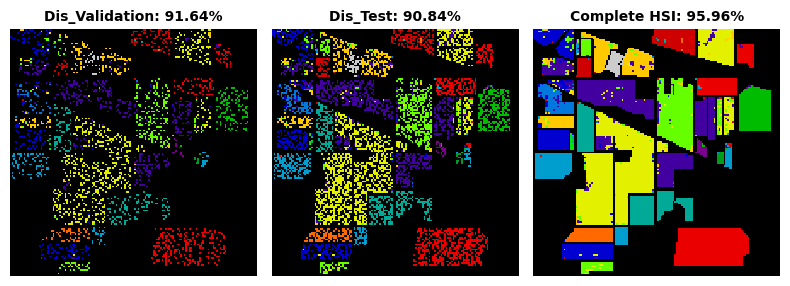

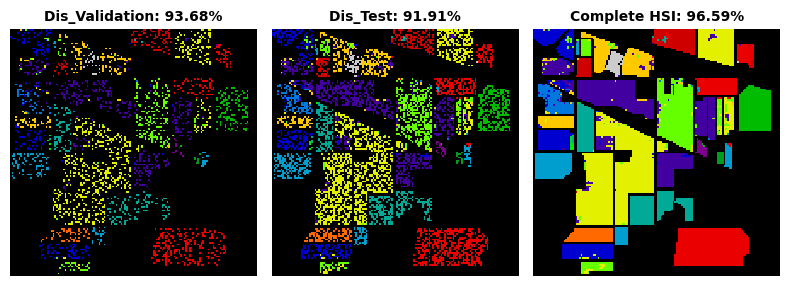

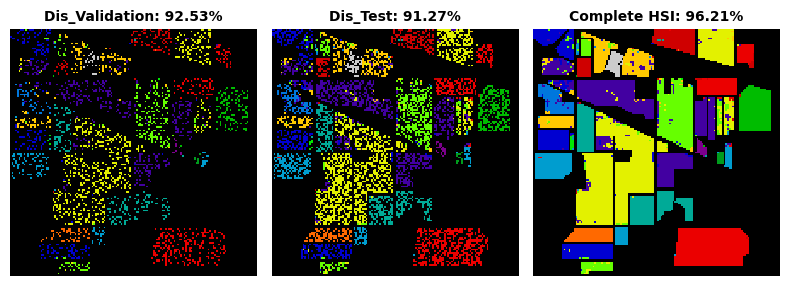

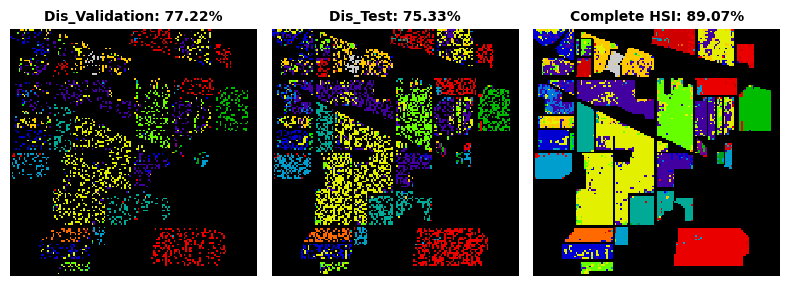

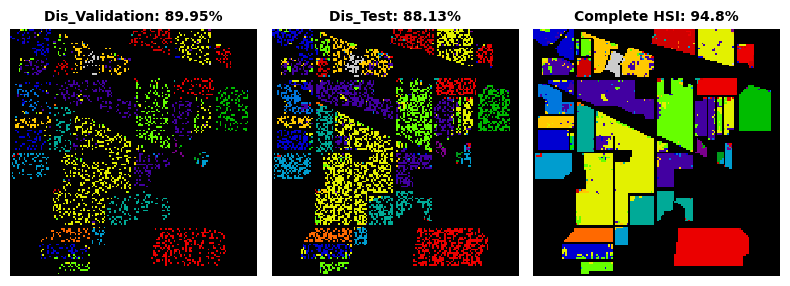

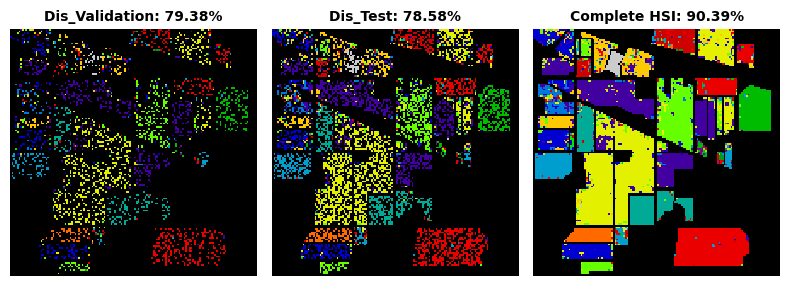

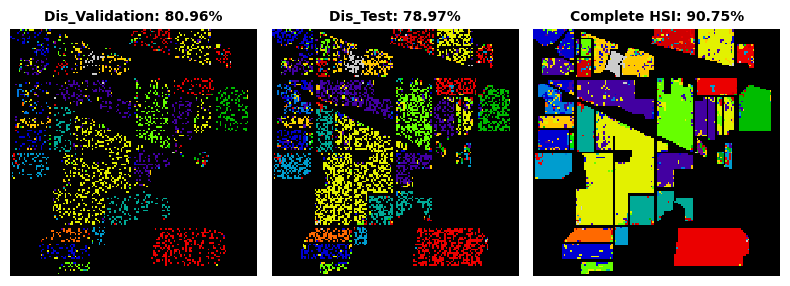

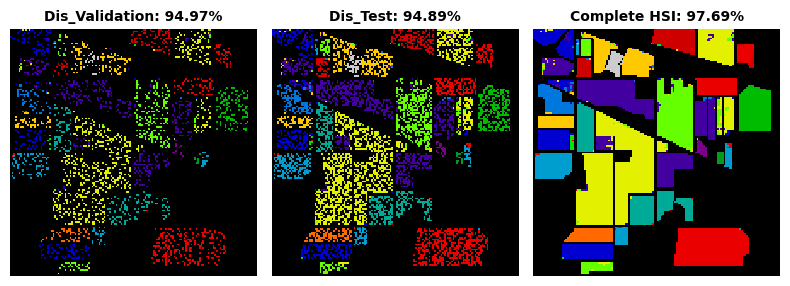

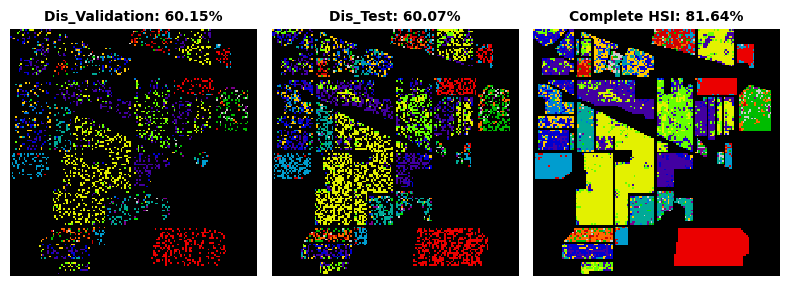

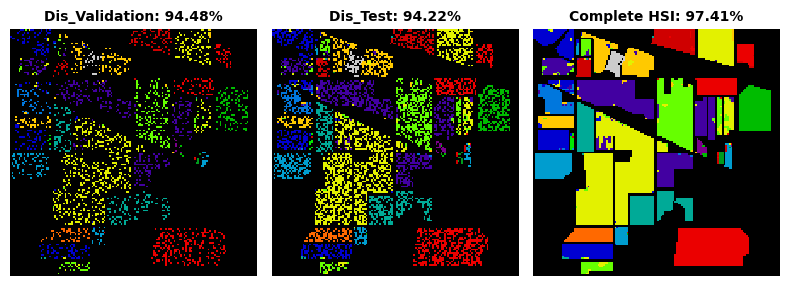

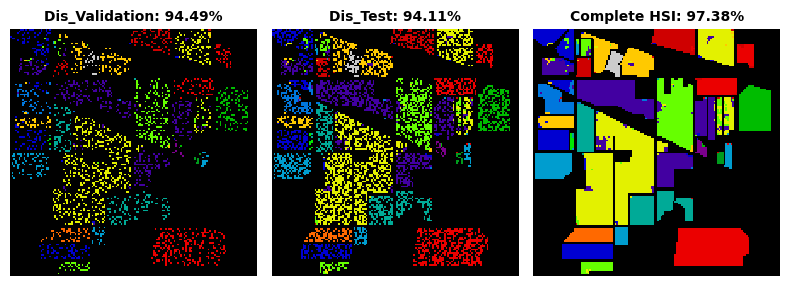

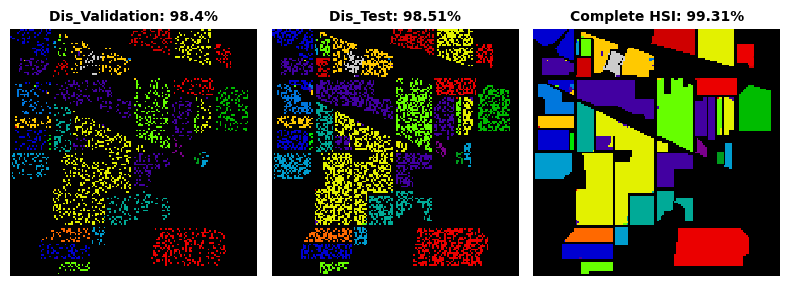

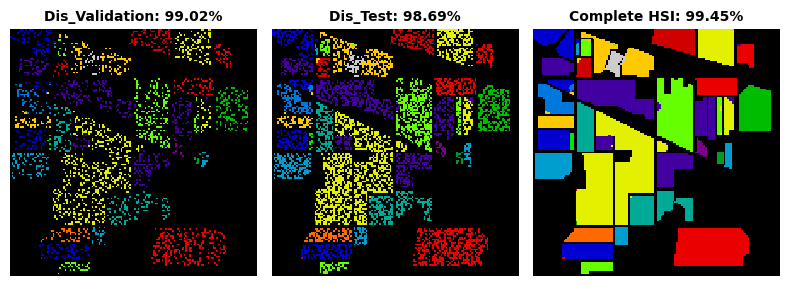

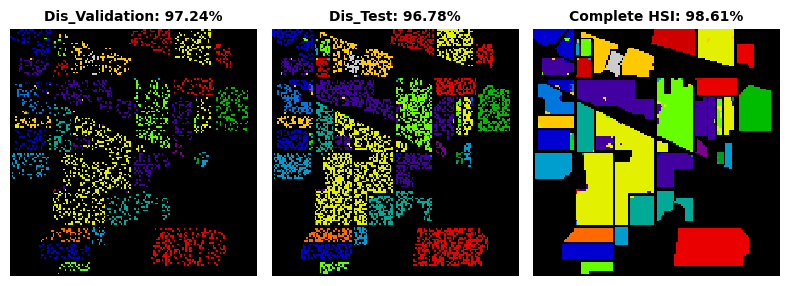

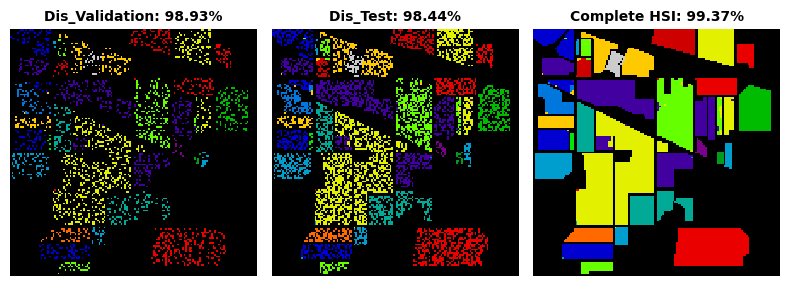

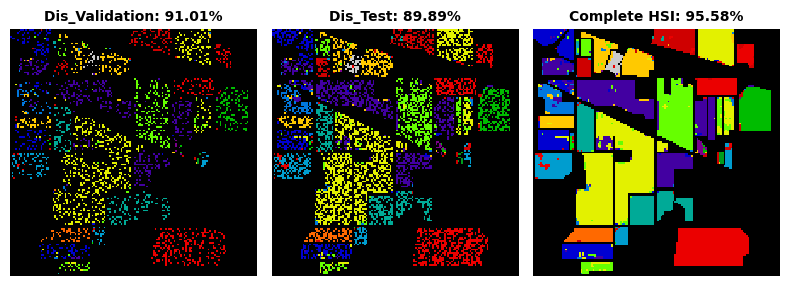

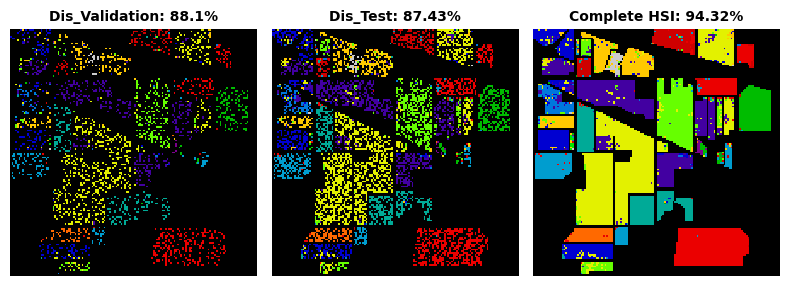

In [ ]:
## Define a list of model names
model_names = [HybridFormer, SSMamba, MHSAMamba, WaveMamba, MorpMamba, Xtreme_Exception, 
Exception2D, CNN2D, IN2D, IN3D, HybIN, CNN3D, HybCNN, AttentionGCN, SCSNet] ## PyFormer
# model_names = [SSMamba, MHSAMamba, WaveMamba, MorpMamba, Xtreme_Exception, Exception2D, CNN2D, 
# IN2D, IN3D, HybIN, CNN3D, HybCNN, AttentionGCN, SCSNet, WaveFormer, SSFormer, HybridFormer]
# Loop over the model names
history_list = []
for model_name in model_names:
    history = train_and_evaluate_model(model_name, Tr, TrC, Va, VaC, Te, TeC,
                                       adam, CRDHSI, HSID, teRatio, k, WS,
                                       RDHSI, GT, Num_Classes, batch_size,
                                       epochs, val_matrix, VaInd,
                                       test_matrix, TeInd, flattened)
    history_list.append(history)

**Accuracy & Loss Curves**

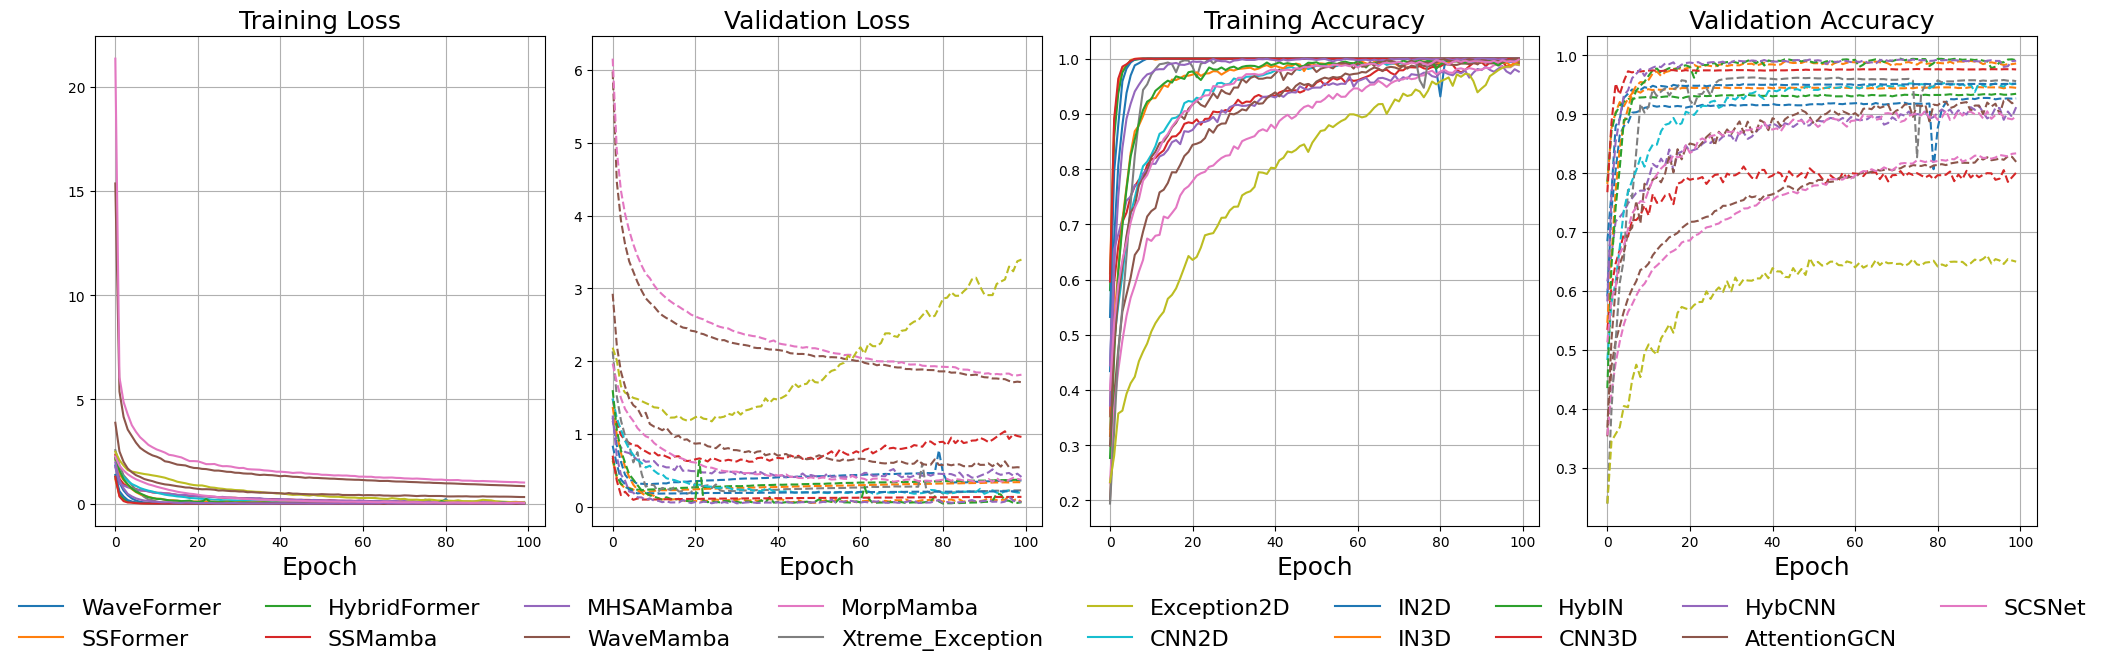

In [36]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6))
legend_labels = []
for i, history in enumerate(history_list):
    axs[0].plot(history.history['loss'], label=f'{model_names[i].__name__} Train')
    axs[1].plot(history.history['val_loss'], label=f'{model_names[i].__name__} Val', linestyle='--')
    axs[2].plot(history.history['accuracy'], label=f'{model_names[i].__name__} Train')
    axs[3].plot(history.history['val_accuracy'], label=f'{model_names[i].__name__} Val', linestyle='--')    
    legend_labels.append(f'{model_names[i].__name__}')
    # legend_labels.append(f'{model_names[i].__name__} Val')

axs[0].set_title('Training Loss', fontsize=18)
axs[0].set_xlabel('Epoch', fontsize=18)
axs[1].set_title('Validation Loss', fontsize=18)
axs[1].set_xlabel('Epoch', fontsize=18)
axs[2].set_title('Training Accuracy', fontsize=18)
axs[2].set_xlabel('Epoch', fontsize=18)
axs[3].set_title('Validation Accuracy', fontsize=18)
axs[3].set_xlabel('Epoch', fontsize=18)
for ax in axs:
    ax.grid(True)
fig.legend(legend_labels, loc='center', fontsize=16, ncol=9, bbox_to_anchor=(0.5, -0.05), frameon=False)
plt.tight_layout()
file_name = f"{HSID}_{teRatio}_{k}_{WS}_acc_loss_curve_all_models.png"
plt.savefig(file_name, dpi=600, format='png', bbox_inches='tight', pad_inches=0)
plt.show()